In [ ]:
# Created by: Dhruv Bejugam
# Last Updated on: 07/21/22
# Summary: PyTorch PDE Approximator created using previous implementation and research
# References: "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations" By M.Raissi, P.Perdikaris, and G.E.Karniadakis + "Physics-Informed-Neural-Networks" by Siddesh Sambasivam

In [ ]:
# importing required packages
from collections import OrderedDict
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
from pylab import meshgrid
import scipy.io
import torch 
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

In [ ]:
# setting seed for generating random numbers
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# loading in data
data_dict = scipy.io.loadmat("burgers_shock.mat")

# n_u is # of initial and boundary points, n_f is # of collocation points
n_u, n_f = 100, 10000

# setting data to variables
x_data,t_data, u_data = data_dict['x'], data_dict['t'], data_dict['usol']
x_data.shape, t_data.shape, u_data.shape

((256, 1), (100, 1), (256, 100))

In [ ]:
# creating a rectangular grid out of 't_data' and 'x_data' one-dimensional arrays representing Cartesian or Matrix indexing
u_t, u_x = meshgrid(t_data, x_data)
u_t.shape, u_x.shape

((256, 100), (256, 100))

In [ ]:
# establishing variable as flattened 'u_data'
u_data_transformed = u_data.flatten()[:, None] # (25600,1)

# establishing variable as stack of flattened x and t data (in sequence horizontally)
training_points = np.hstack((u_t.flatten()[:, None], u_x.flatten()[:, None])) # (25600, 2)

In [ ]:
IC_X, IC_Y = list(), list() # initial and boundary points
CC_X, CC_Y = list(), list() # collocation points

# going through points and adding points to respective lists
for idx, sample in enumerate(training_points):
    
    t, x = sample
    if t in [0,1] or x in [-1,1]: 
        IC_X.append(sample)
        IC_Y.append(u_data_transformed[idx])
    else:
        CC_X.append(sample)
        CC_Y.append(u_data_transformed[idx])
        
IC_X = np.array(IC_X)
IC_Y = np.array(IC_Y)

CC_X = np.array(CC_X)
CC_Y = np.array(CC_Y)

In [ ]:
n_u_idx = list(np.random.choice(len(IC_X), n_u))
n_f_idx = list(np.random.choice(len(CC_X), n_f))

# setting points as tensors
u_x = torch.tensor(IC_X[n_u_idx, 1:2], requires_grad=True).float()
u_t = torch.tensor(IC_X[n_u_idx, 0:1], requires_grad=True).float()
u_u = torch.tensor(IC_Y[n_u_idx, :], requires_grad=True).float()

f_x = torch.tensor(CC_X[n_f_idx, 1:2], requires_grad=True).float()
f_t = torch.tensor(CC_X[n_f_idx, 0:1], requires_grad=True).float()
f_u = torch.tensor(CC_Y[n_f_idx, :], requires_grad=True).float()

# establishing training data
train_x = torch.cat((u_x, f_x), dim=0)
train_t = torch.cat((u_t, f_t), dim=0)
train_u = torch.cat((u_u, f_u), dim=0)

In [ ]:
# establishing neural network class 
class PhysicsINN(nn.Module):
    
    def __init__(self, num_layers:int=2, num_neurons:int=20) -> None:
        
        super(PhysicsINN, self).__init__()
        
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        
        # Each hidden layer contained 20 neurons and a hyperbolic tangent activation function.
        self.activation_func = torch.nn.Tanh
        
        ordered_layers = list()
                
        ordered_layers.append(("input_layer", nn.Linear(2, self.num_neurons)))
        ordered_layers.append(("input_activation", self.activation_func()))
        
        # Create num_layers-2 linear layers with num_neuron neurons and tanh activation function
        for i in range(self.num_layers-2):
            
            ordered_layers.append(("layer_%d" % (i+1), nn.Linear(self.num_neurons, self.num_neurons)))
            ordered_layers.append(("layer_%d_activation" % (i+1), self.activation_func()))
                        
        ordered_layers.append(("output_layer", nn.Linear(self.num_neurons, 1)))
        
        self.net = nn.Sequential(OrderedDict(ordered_layers))    
        
        self.init_weights()

    # initializing weights    
    def init_weights(self, ) -> None:
        for param in self.parameters():
            if len(param.shape) >= 2: torch.nn.init.xavier_normal_(param, )
            elif len(param.shape) == 1: torch.nn.init.zeros_(param)

    # forward function    
    def forward(self, inputs) -> torch.Tensor:
        out = self.net(inputs)
        return out 

# instantiating model 
model = PhysicsINN(4, 40)

print(model)

PhysicsINN(
  (net): Sequential(
    (input_layer): Linear(in_features=2, out_features=40, bias=True)
    (input_activation): Tanh()
    (layer_1): Linear(in_features=40, out_features=40, bias=True)
    (layer_1_activation): Tanh()
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (layer_2_activation): Tanh()
    (output_layer): Linear(in_features=40, out_features=1, bias=True)
  )
)


In [ ]:
EPOCHS = 100
optimizer = torch.optim.LBFGS(model.parameters())

t_bar = trange(EPOCHS)

# training model
for epoch in t_bar:
    
    def closure():
        optimizer.zero_grad()
        
        output = model(torch.cat((train_t, train_x), dim=1))
        
        u_grad_x =  torch.autograd.grad(output, train_x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        u_grad_xx = torch.autograd.grad(u_grad_x, train_x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        
        u_grad_t = torch.autograd.grad(output, train_t, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(output),allow_unused=True)[0]
        
        f = u_grad_t + output*u_grad_x - (0.01/np.pi) * u_grad_xx
        
        mse_f = torch.mean(torch.square(f))
        mse_u = torch.mean(torch.square(output - train_u))
        
        loss = mse_f + mse_u
        
        loss.backward()
        
        t_bar.set_description("loss: %.20f" % loss.item())
        t_bar.refresh() 
    
        return loss
    
    optimizer.step(closure)

loss: 0.00033684953814372420: 100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


In [ ]:
# getting plotting values
test_X = [[], [], []]
test_Y = [[], [], []]

for idx, sample in enumerate(training_points):
    
    t, x = sample
    if t == 0.33:
        test_X[0].append(sample)
        test_Y[0].append(u_data_transformed[idx])
        
    if t == 0.66:
        test_X[1].append(sample)
        test_Y[1].append(u_data_transformed[idx])        
        
    if t == 0.99:
        test_X[2].append(sample)
        test_Y[2].append(u_data_transformed[idx])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


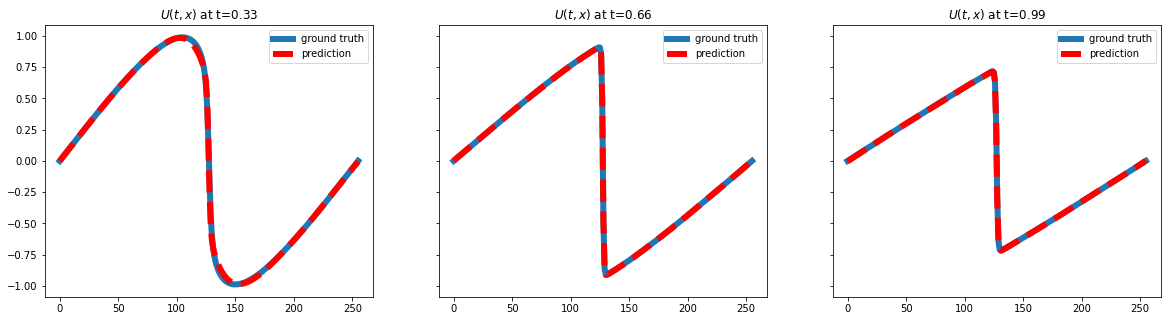

In [ ]:
# plotting the solution at different t values
fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,5))
width = 6

for i,t in enumerate([0.33, 0.66, 0.99]):
    
    axs[i].set_title(f"$U(t,x)$ at t={t}")
    axs[i].plot(test_Y[i],  linewidth=width, label="ground truth")
    axs[i].plot(model(torch.tensor(test_X[i]).float()).detach().numpy(), "r--", linewidth=width, label='prediction')
    axs[i].legend(loc='upper right')

In [ ]:
# saving model as TorchScript model for C++
traced_script_module = torch.jit.trace(model, torch.cat((train_t, train_x), dim=1))
traced_script_module.save("PyTorch_PDE_Approximator.pt")